In [1]:
# Data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers

import transformers

# Visualization
from matplotlib import pyplot as plt

# Text processing
import re
import nltk
import gensim.downloader as api

# Various
from datetime import datetime

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [44]:
# Select the dataset for the analysis
df = pd.read_csv("Labelled_Datasets/final_3label01.csv")
df = df[["sentence", "label"]]

# Show the data
df.head()

,sentence,label
0,usage and adverse effects of identified mtbfad...,0
1,long-term maternal administration of ritodrine...,0
2,/1010 assessed for eligibility (n=001) exclude...,0
3,35 this is an important consideration when com...,0
4,"thus, hospital admission in itself is a severe...",0


In [45]:
print('Total number of news: {}'.format(len(df)))
print(40*'-')
print('Split by category:')
print(df["label"].value_counts())
print(40*'-')
nr_categories = len(df["label"].unique())
print("Number of categories: {n}".format(n=nr_categories))

Total number of news: 828
----------------------------------------
Split by category:
1    528
0    300
Name: label, dtype: int64
----------------------------------------
Number of categories: 2


In [46]:
# You can adjust n:
n=100
print('Category: ',df['label'][n])
print(100*'-')
print('Text:')
print(df['sentence'][n])

Category:  0
----------------------------------------------------------------------------------------------------
Text:
although naltrexone/bupropion may increase blood pressure and should therefore not be used in patients with uncontrolled hypertension, no adverse signal for increased cardiovascular events was found in the interim analysis of a cardiovascular outcome trial 75 .in 1004, liraglutide 3 mg became the first glp0-based aom to be introduced to the us market for treatment of obesity in adults, and in 1010 was approved for weight management in adolescents aged 01 years and older with obesity (see related links).


In [47]:
# Renaming, Input -> X, Output -> y
X_tf = df['sentence']
y_tf_class = df['label']
#Convert labels into a one-hot vector of size 5 (the number of distinct labels)
# lab = LabelBinarizer()
# lab.fit(y_tf_class)
# y_tf = lab.transform(y_tf_class)
n=100
print('Coding of labels into a one-hot vector: ' +str(y_tf_class[n]) + ' is ', y_tf_class[n])

# Split into training and test data
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y_tf_class, test_size=0.2, random_state=42, stratify=df['label'])
y_test

Coding of labels into a one-hot vector: 0 is  0


NameError: name 'y_test' is not defined

In [48]:
corpus = X_tf_train
max_words = 2000
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

In [49]:
max_len = 300
sequences = tokenizer.texts_to_sequences(X_tf_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)
# Apply the same to test data
X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_tf_test), maxlen=max_len)
n=10 # You can adjust n
print('Shape: ',X_tf_train_seq.shape)
print(100*'-')
print('Example: ',X_tf_train_seq[n,:])

Shape:  (662, 300)
----------------------------------------------------------------------------------------------------
Example:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   

In [22]:
# This may take several minutes
w2v = api.load("word2vec-google-news-300")
# Example of a word representation:
w2v['hello'].shape
(300,)
# Build weights of the embbeddings matrix using w2v
emb_matrix=np.zeros((max_words+1, 300))
for i in range(max_words):
    w = reverse_voc[i+1]
    if w in w2v:
      emb_matrix[i+1,:] = w2v[w]
emb_size = emb_matrix.shape[1]

In [50]:
input_ = layers.Input(shape = X_tf_train_seq[0,:].shape,name='input')
# Embedding layer (voc size plus un ("UNK", word with index 0)), using the pre-trained emb_matrix obtained from Word2Vec
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(1,activation='sigmoid', name='classification')(x)
model = models.Model(input_, output)
opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 300)          600300    
_________________________________________________________________
bidirectional-lstm (Bidirect (None, 30)                37920     
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1984      
_________________________________________________________________
classification (Dense)       (None, 1)                 65        
Total params: 640,269
Trainable params: 39,969
Non-trainable params: 600,300
________________________________________________

In [52]:
# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs. 
import keras
from keras.callbacks import EarlyStopping
es = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                   mode = 'min',
                                   patience = 50,
                                   restore_best_weights = True,
                                   verbose= 1)

In [53]:
start_time = datetime.now()
history = model.fit(X_tf_train_seq, y_tf_train, batch_size=32, shuffle=True, callbacks = [es], verbose=1, epochs=100, validation_data=(X_tf_test_seq, y_tf_test))
end_time = datetime.now()
training_time_rnn = (end_time - start_time).total_seconds()

Epoch 1/100
21/21 [==============================] - 3s 87ms/step - loss: 0.6732 - accuracy: 0.6239 - val_loss: 0.6393 - val_accuracy: 0.6506
Epoch 2/100
21/21 [==============================] - 1s 68ms/step - loss: 0.6188 - accuracy: 0.6616 - val_loss: 0.6176 - val_accuracy: 0.6867
Epoch 3/100
21/21 [==============================] - 1s 66ms/step - loss: 0.5468 - accuracy: 0.7130 - val_loss: 0.5821 - val_accuracy: 0.7048
Epoch 4/100
21/21 [==============================] - 1s 68ms/step - loss: 0.4575 - accuracy: 0.7613 - val_loss: 0.4631 - val_accuracy: 0.7410
Epoch 5/100
21/21 [==============================] - 1s 68ms/step - loss: 0.4360 - accuracy: 0.7659 - val_loss: 0.5518 - val_accuracy: 0.7108
Epoch 6/100
21/21 [==============================] - 1s 67ms/step - loss: 0.3629 - accuracy: 0.8293 - val_loss: 0.4504 - val_accuracy: 0.8554
Epoch 7/100
21/21 [==============================] - 1s 67ms/step - loss: 0.1924 - accuracy: 0.9396 - val_loss: 0.2812 - val_accuracy: 0.9217
Epoch 

21/21 [==============================] - 1s 67ms/step - loss: 6.8087e-04 - accuracy: 1.0000 - val_loss: 0.4051 - val_accuracy: 0.9699
Epoch 59/100
21/21 [==============================] - 1s 68ms/step - loss: 4.7848e-04 - accuracy: 1.0000 - val_loss: 0.4076 - val_accuracy: 0.9699
Epoch 60/100
21/21 [==============================] - 1s 67ms/step - loss: 5.7442e-04 - accuracy: 1.0000 - val_loss: 0.4163 - val_accuracy: 0.9699
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping


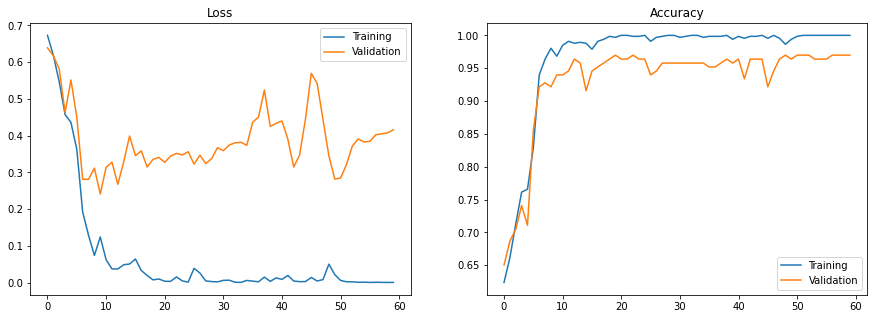

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [55]:
accuracy_rnn = history.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f}s'.format(training_time_rnn))

Accuracy Training data: 100.0%
Accuracy Test data: 97.0%
Training time: 86.9s


In [57]:
y_tf_test

811    1
298    0
605    1
391    1
641    1
      ..
350    1
270    0
43     0
214    0
519    1
Name: label, Length: 166, dtype: int64

In [59]:
import tensorflow as tf
#y_pred = tf.nn.softmax(model.predict(X_tf_test_seq))
#y_pred_argmax = tf.math.argmax(y_pred, axis=1)
#y_tf_test= y_tf_test.argmax(axis=1)
#y_tf_test = y_tf_test.flatten()
y_tf_test

811    1
298    0
605    1
391    1
641    1
      ..
350    1
270    0
43     0
214    0
519    1
Name: label, Length: 166, dtype: int64

In [60]:
y_predict = model.predict(X_tf_test_seq)
y_predict = y_predict.flatten()
y_predict = np.where(y_predict > 0.5, 1, 0)
y_predict

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1])

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
cm = confusion_matrix(y_tf_test, y_predict)
cm

array([[ 52,   8],
       [  2, 104]])

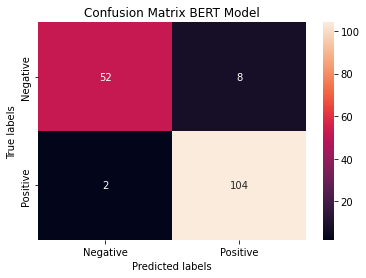

In [66]:
ax= plt.subplot()
conf_matrix = pd.DataFrame(cm)
conf_matrix=sns.heatmap(cm, annot=True, fmt='g', ax=ax);
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
ax.set_title('Confusion Matrix BERT Model'); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_tf_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91        60
           1       0.93      0.98      0.95       106

    accuracy                           0.94       166
   macro avg       0.95      0.92      0.93       166
weighted avg       0.94      0.94      0.94       166



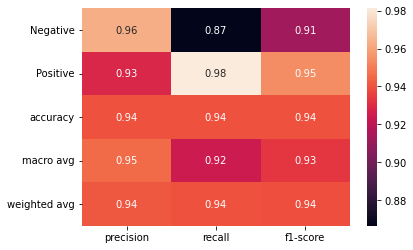

In [68]:
clf_report_nn = classification_report(y_tf_test, y_predict, labels=[0, 1 ], target_names=['Negative', 'Positive'], output_dict=True)
sns.heatmap(pd.DataFrame(clf_report_nn).iloc[:-1, :].T, annot=True)
ax.set_title('Classification Report RNN Network'); 

In [69]:
corpus_results = pd.read_csv('Results/corpus.csv')

In [84]:
corpus_results.label.value_counts()

Positive    554199
Negative     32834
Name: label, dtype: int64

In [71]:
sequences = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(corpus_results['sentence']), maxlen=max_len)

In [72]:
predictions = model.predict(sequences)

In [73]:
predictions[0:10]

array([[0.95530665],
       [0.95530665],
       [0.95530665],
       [0.8962023 ],
       [0.9854861 ],
       [0.9423294 ],
       [0.9632846 ],
       [0.8614813 ],
       [0.8614813 ],
       [0.99087346]], dtype=float32)

In [74]:
corpus_results['confidence'] = predictions

In [80]:
corpus_results['label'] = corpus_results.confidence.apply(lambda x: 'Positive' if x > 0.5 else 'Negative')

In [89]:
corpus_results[corpus_results['label'] == 'Negative']

,cord_uid,sentence,drug,disease,confidence,label
612,12hn49x2,patients with a prior history of stroke before...,Date,heart disease,0.929226,Negative
613,12hn49x2,patients with a prior history of stroke before...,Date,peripheral vascular disease,0.929226,Negative
614,12hn49x2,"censored at earliest of outcome of interest, d...",Date,heart disease,0.998537,Negative
615,12hn49x2,"censored at earliest of outcome of interest, d...",Date,peripheral vascular disease,0.998537,Negative
635,po144zi3,"according to a systematic review article, chem...",Doxycycline,leptospirosis,0.999346,Negative
...,...,...,...,...,...,...
586779,f85yhu69,the adverse events of statins are dose depende...,Vitamin D,myopathy,0.971664,Negative
586780,f85yhu69,the adverse events of statins are dose depende...,Vitamin D,hypothyroidism,0.971664,Negative
586781,f85yhu69,the adverse events of statins are dose depende...,Vitamin D,fibromyalgia,0.971664,Negative
586905,qvmfotkv,"second, the daily confirmed new covid-19 cases...",Turkey,COVID-19,0.906553,Negative


In [88]:
corpus_results['confidence'] = corpus_results.apply(lambda x: x.confidence if x.label == 'Positive' else 1 - x.confidence, axis=1)

In [90]:
corpus_results.to_csv('Results/final_results_after_model_application.csv', index=False)

In [103]:
!zip -r final_results_after_model_application.zip Results/final_results_after_model_application.csv

  adding: Results/final_results_after_model_application.csv (deflated 92%)


In [92]:
altMedicine = pd.read_csv('Results/corpus_AM.csv')

In [94]:
altMedicineSeqs = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(altMedicine['sentence']), maxlen=max_len)

In [95]:
altPredictios = model.predict(altMedicineSeqs)

In [98]:
altPredictios[0:10]

array([[0.9742477 ],
       [0.9742477 ],
       [0.6911124 ],
       [0.9586606 ],
       [0.9137657 ],
       [0.96949   ],
       [0.95906067],
       [0.97537196],
       [0.90322125],
       [0.9644052 ]], dtype=float32)

In [99]:
altMedicine['confidence'] = altPredictios

In [100]:
altMedicine['label'] = altMedicine.confidence.apply(lambda x: 'Positive' if x > 0.5 else 'Negative')

In [101]:
altMedicine['confidence'] = altMedicine.apply(lambda x: x.confidence if x.label == 'Positive' else 1 - x.confidence, axis=1)

In [102]:
altMedicine.to_csv('Results/final_raltMedicine_after_model_application.csv', index=False)